In [4]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [5]:
# load the data for each station
files = os.listdir(f'./data/processed/cycle_counter/Stadt_Heidelberg/')

In [6]:
counter_scheme = {
        "operator_name": pl.String,
        "domain_name": pl.String,
        "domain_id": pl.Int32,
        "counter_site": pl.String,
        "counter_site_id": pl.Int32,
        "counter_serial": pl.String,
        "longitude": pl.Float64,
        "latitude": pl.Float64,
        "timezone": pl.String,
        "iso_timestamp": pl.String,
        "channels_in": pl.Int32,
        "channels_out": pl.Int32,
        "channels_all": pl.Int32,
        "channels_unknown": pl.Int32,
        "site_temperature": pl.Float64,
        "site_rain_accumulation": pl.Float64,
        "site_snow_accumulation": pl.Float64,
    }


tables = [ pl.read_csv(f'./data/processed/cycle_counter/Stadt_Heidelberg/{file}', schema=counter_scheme) for file in files]

#sort tables by date, convert iso_timestamp (2017-03-31T22:00:00+02:00) to datetime
for i in range(len(tables)):
    tables[i] = tables[i].sort("iso_timestamp")
    tables[i] = tables[i].with_columns(pl.col("iso_timestamp").str.strptime(pl.Datetime, format="%Y-%m-%dT%H:%M:%S%z", strict=False).alias("datetime"))

In [7]:
# generate an array of all channels_all column entries
hourly_data = {}
for table in tables:
    start_date = table['iso_timestamp'][0]
    end_data = table['iso_timestamp'][-1]
    station_name = table['counter_site'][0]
    data_all = table['channels_all'].to_numpy()
    hourly_data[station_name] = (data_all, start_date, end_data)

# print the station names and date ranges
for station_name, (data, start_date, end_date) in hourly_data.items():
    print(f'Station: {station_name}, Date Range: {start_date} to {end_date}')

Station: Ernst-Walz-Brücke West - alt, Date Range: 2014-06-01T00:00:00+02:00 to 2018-10-10T22:00:00+02:00
Station: Mannheimer Straße, Date Range: 2015-11-01T00:00:00+01:00 to 2025-10-31T03:00:00+01:00
Station: Thedor-Heuss-Brücke Querschnitt, Date Range: 2018-07-06T06:00:00+02:00 to 2025-10-31T02:00:00+01:00
Station: Schlierbacher Landstraße, Date Range: 2019-02-01T00:00:00+01:00 to 2025-10-31T03:00:00+01:00
Station: Rohrbacher Straße Querschnitt, Date Range: 2018-10-11T00:00:00+02:00 to 2025-10-31T03:00:00+01:00
Station: Ernst-Walz-Brücke Querschnitt, Date Range: 2014-06-01T00:00:00+02:00 to 2025-10-31T03:00:00+01:00
Station: Liebermannstraße, Date Range: 2018-10-11T00:00:00+02:00 to 2025-10-31T03:00:00+01:00
Station: Ziegelhäuser Landstraße, Date Range: 2019-02-01T00:00:00+01:00 to 2025-10-31T03:00:00+01:00
Station: Bahnstadtpromenade, Date Range: 2020-02-01T00:00:00+01:00 to 2025-06-18T14:00:00+02:00
Station: Gaisbergstraße, Date Range: 2015-11-01T00:00:00+01:00 to 2024-12-26T22:00:

In [8]:
def print_series(data, start_date, end_date, station_name):
    # plot the time series as a smooth curve (show raw in light alpha + moving average)
    n = len(data)
    x = np.arange(n)

    # smoothing window: 24 hours if available, otherwise a small window
    window = 24 if n >= 24 else max(3, n // 10)
    smoothed = np.convolve(data, np.ones(window) / window, mode='same')

    plt.figure(figsize=(25, 5))
    plt.plot(x, data, color='gray', alpha=0.25, linewidth=0.5, label='raw')
    plt.plot(x, smoothed, color='tab:blue', linewidth=1.5, label=f'{window}-hour MA')
    # show only start and end on x-axis (positions 0 and last index)
    plt.xticks([0, max(n - 1, 0)], [start_date, end_date])
    plt.title(f'Cycle Counter Data for {station_name}\nfrom {start_date} to {end_date}')
    plt.xlabel('Hours since ' + start_date)
    plt.ylabel('Cycle Counts (All Channels)')
    plt.legend()
    plt.show()

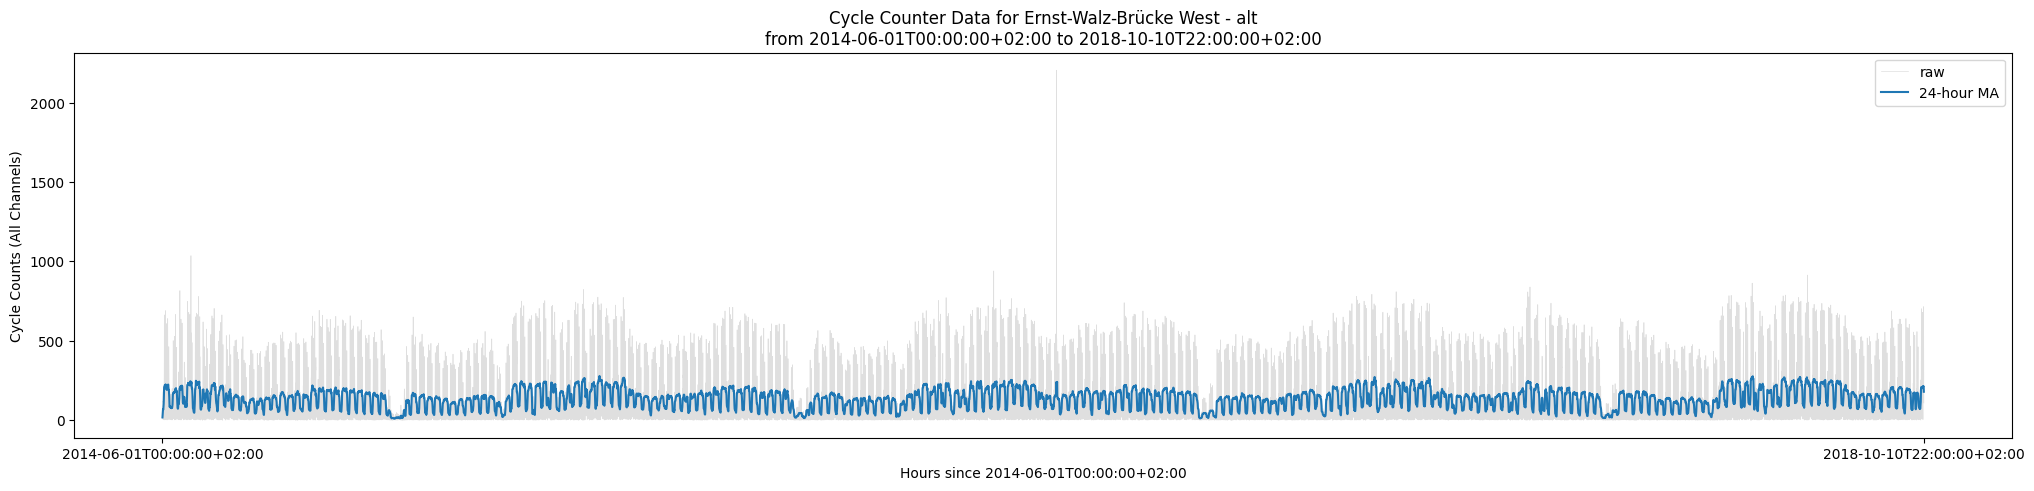

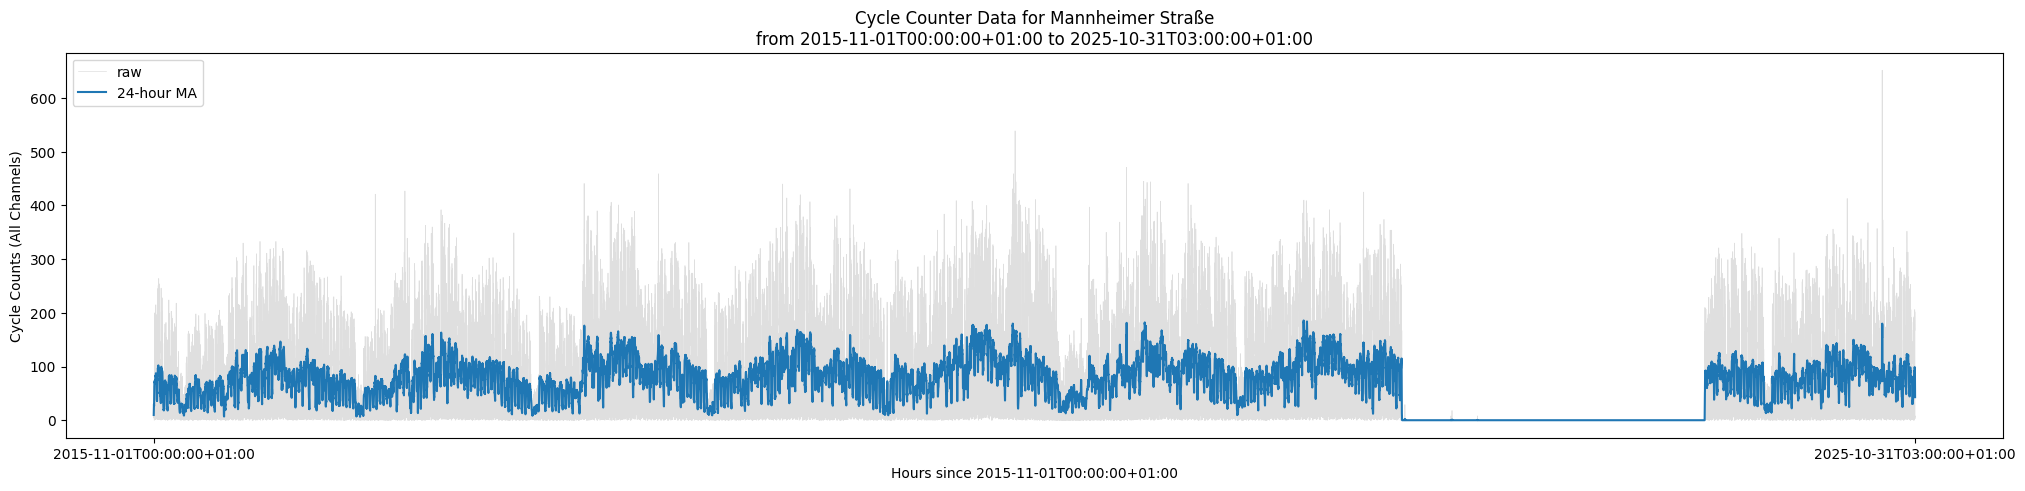

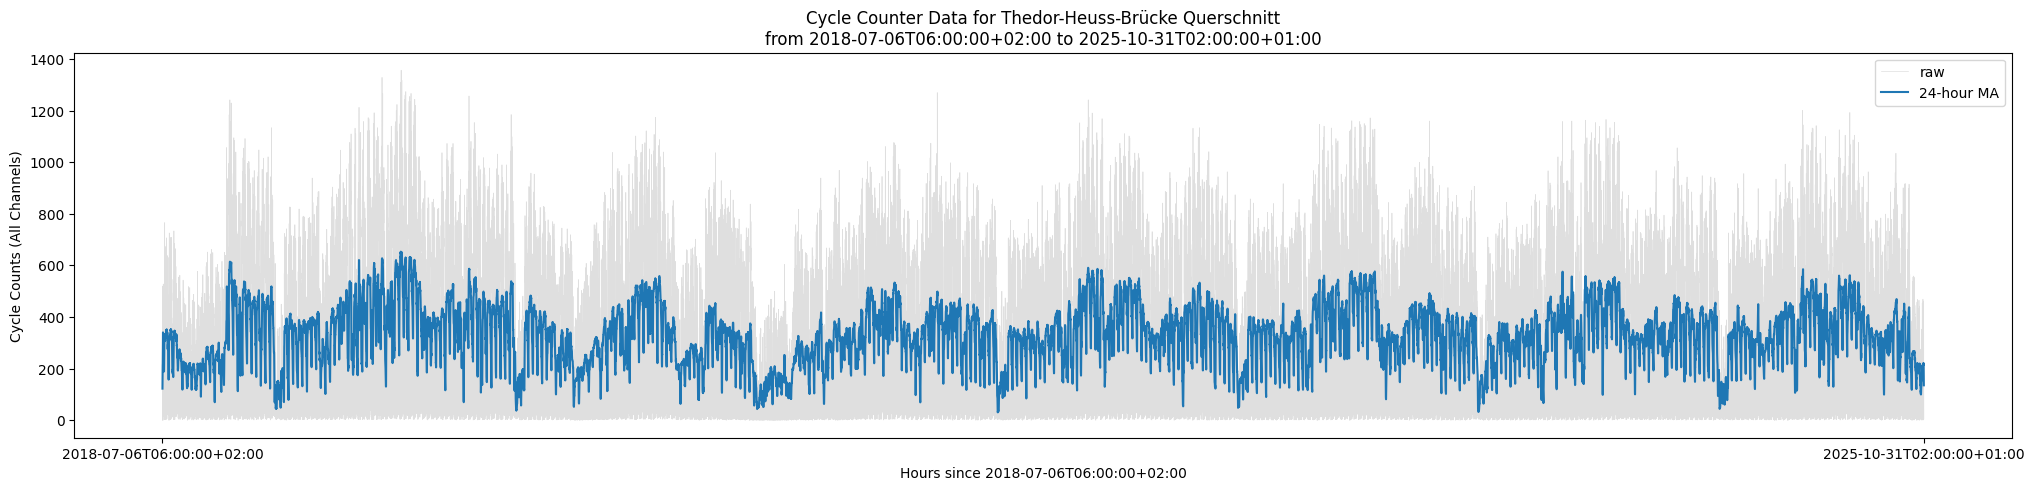

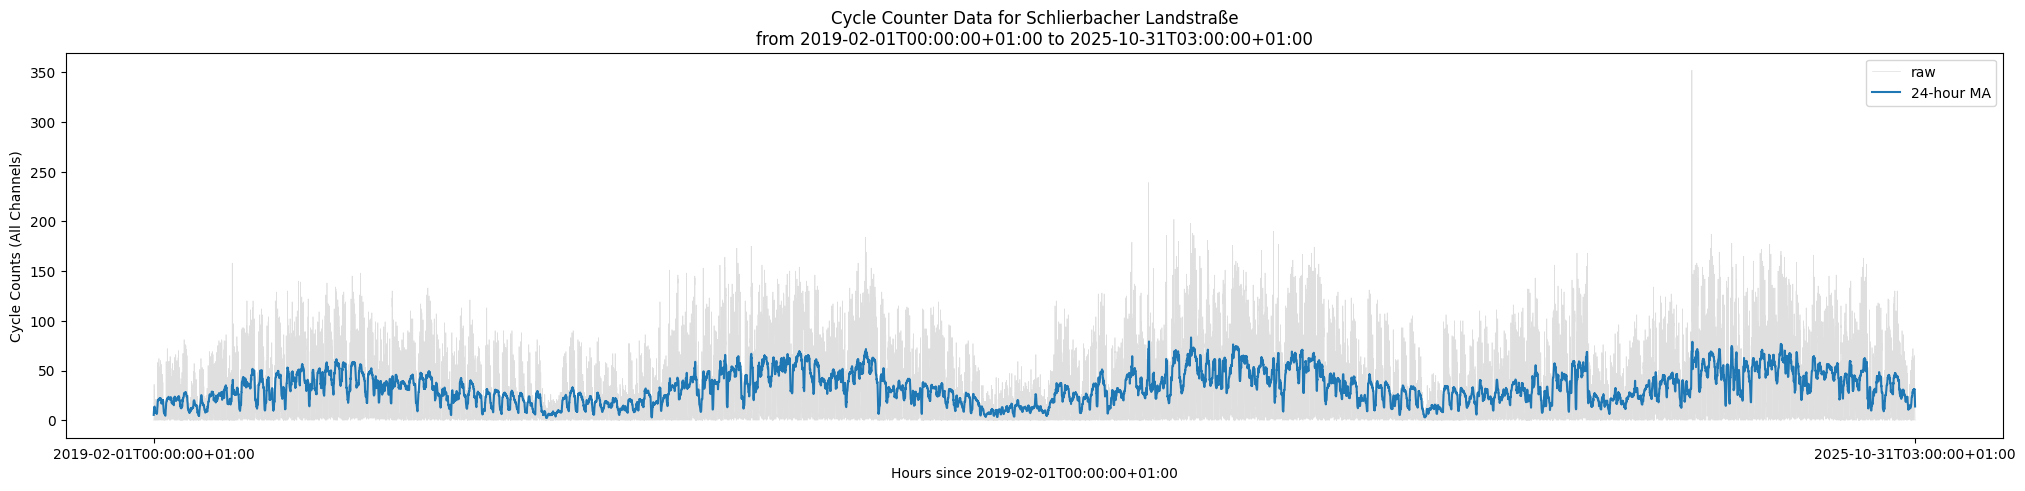

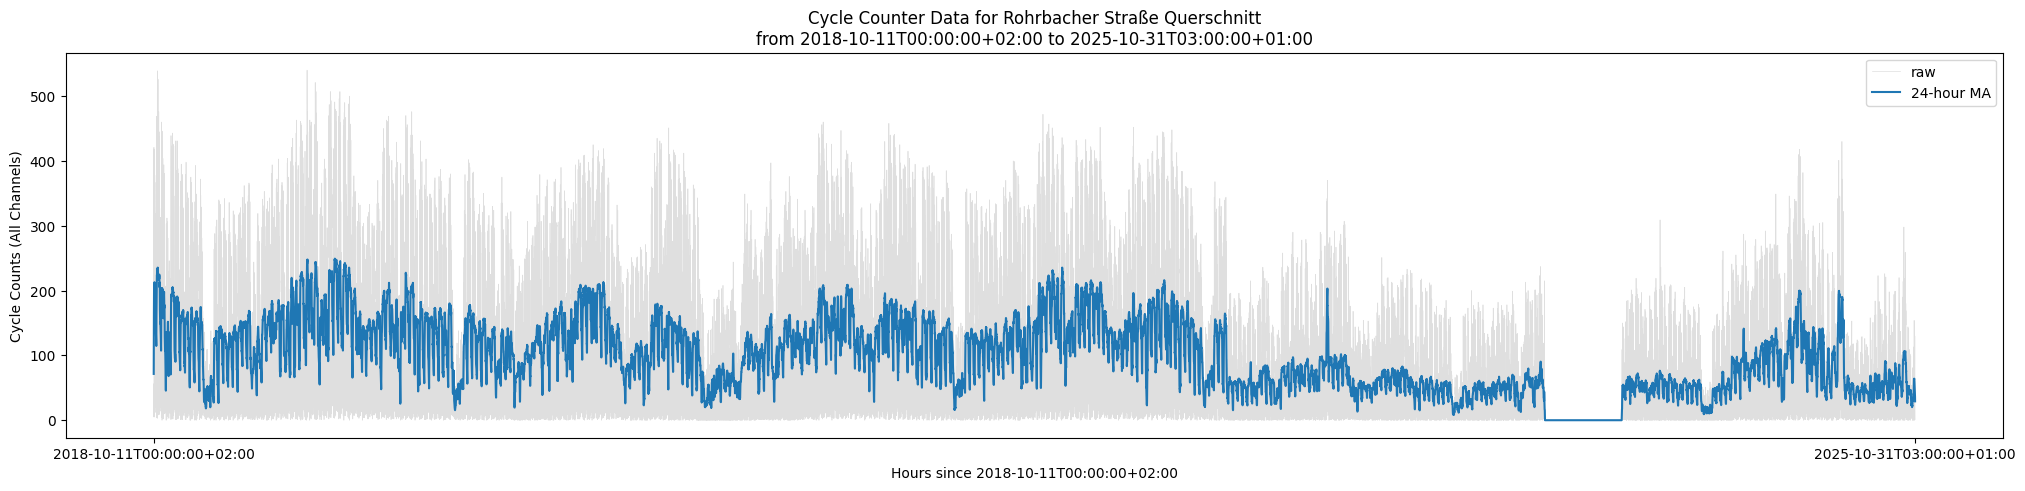

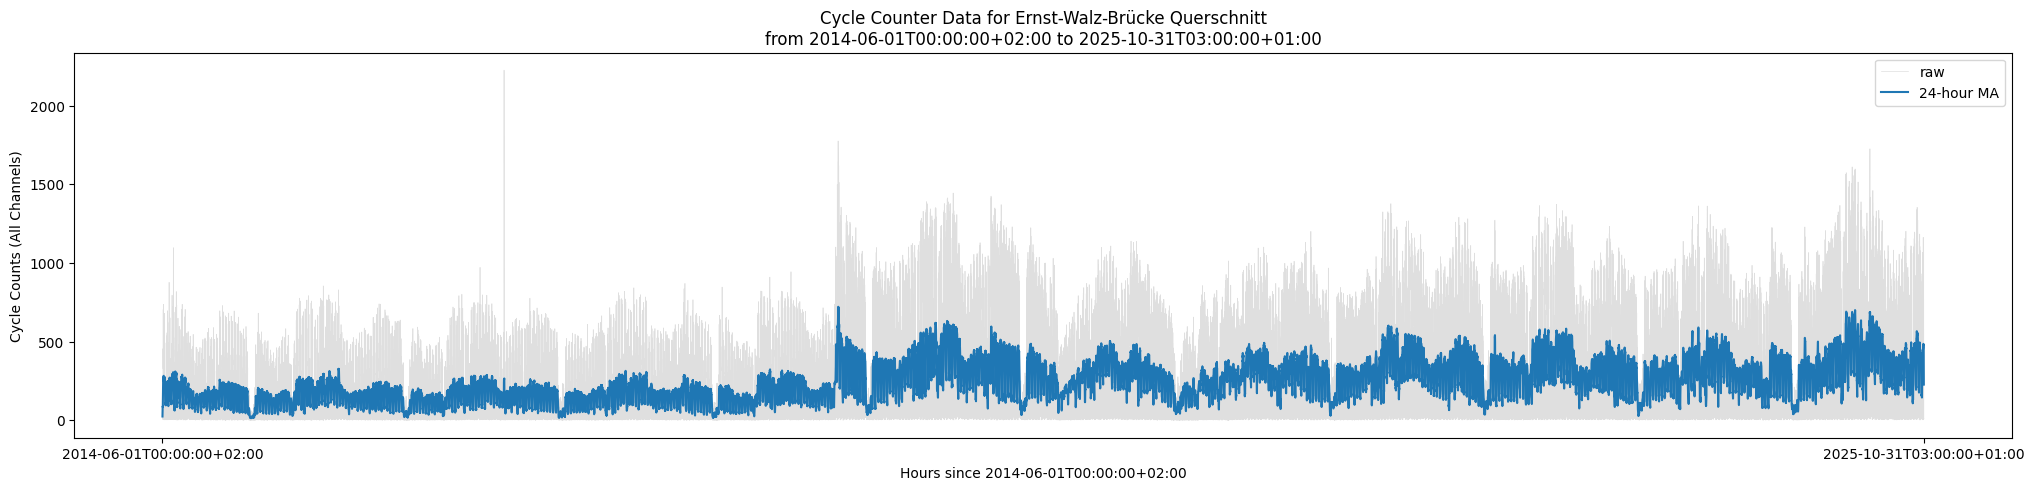

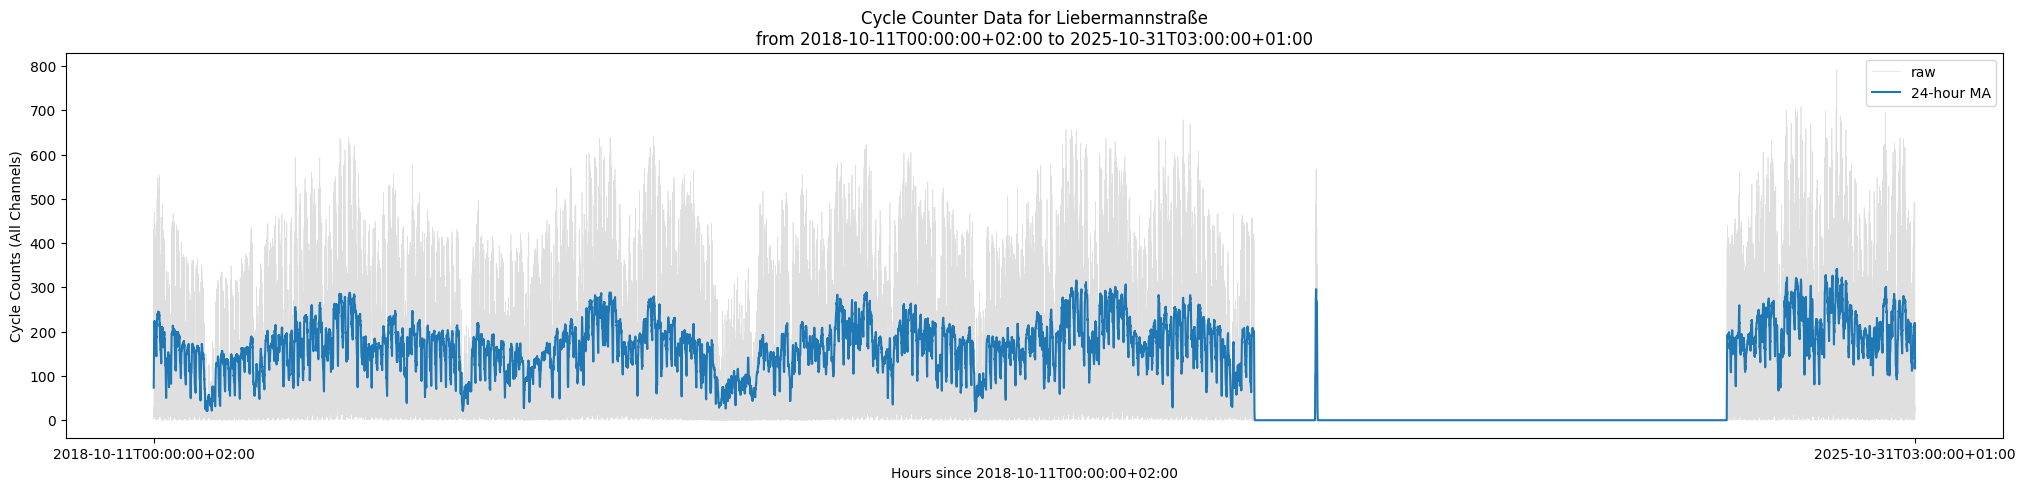

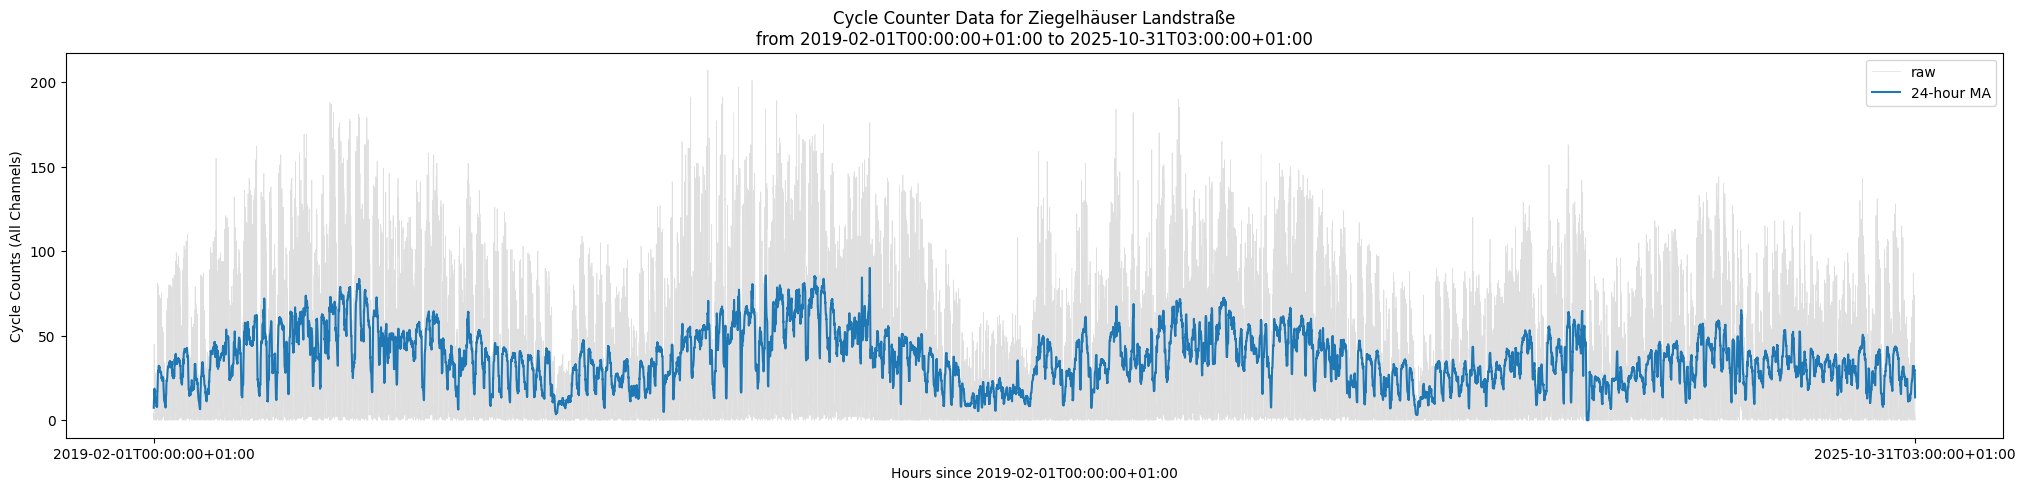

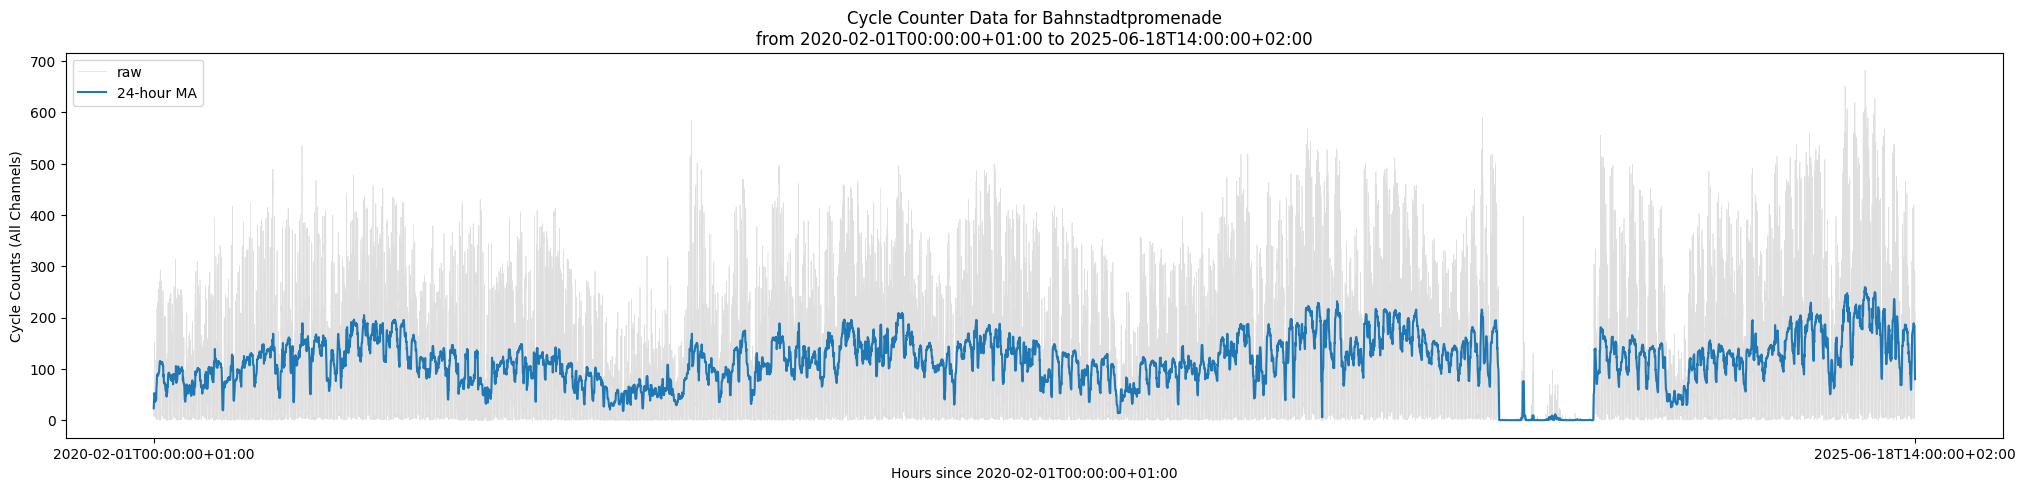

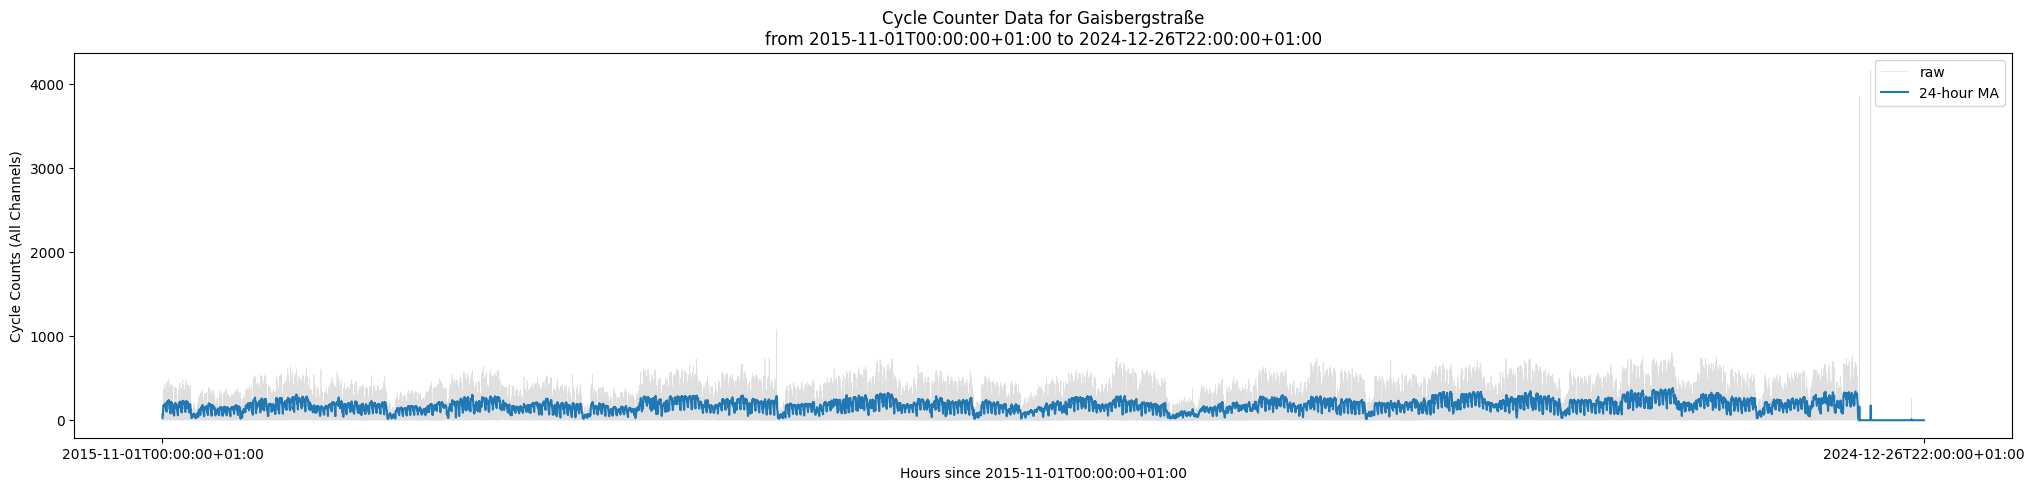

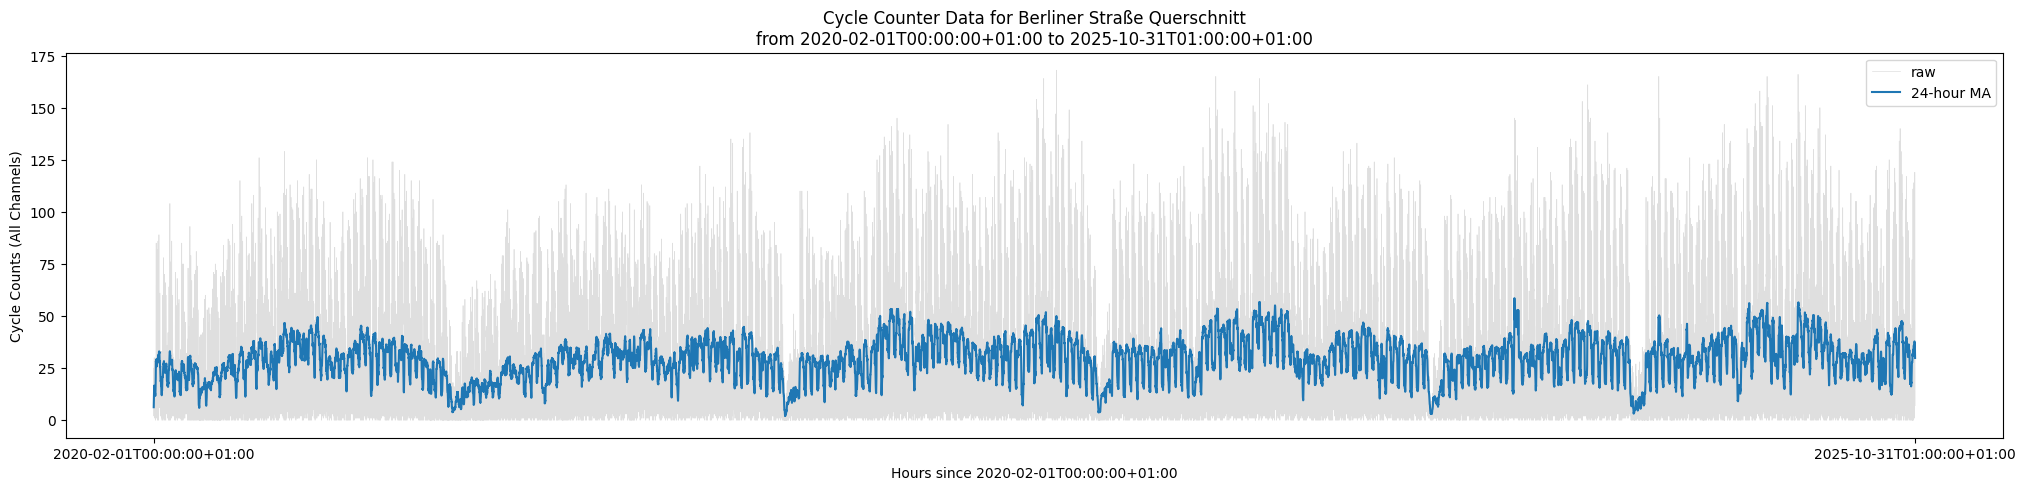

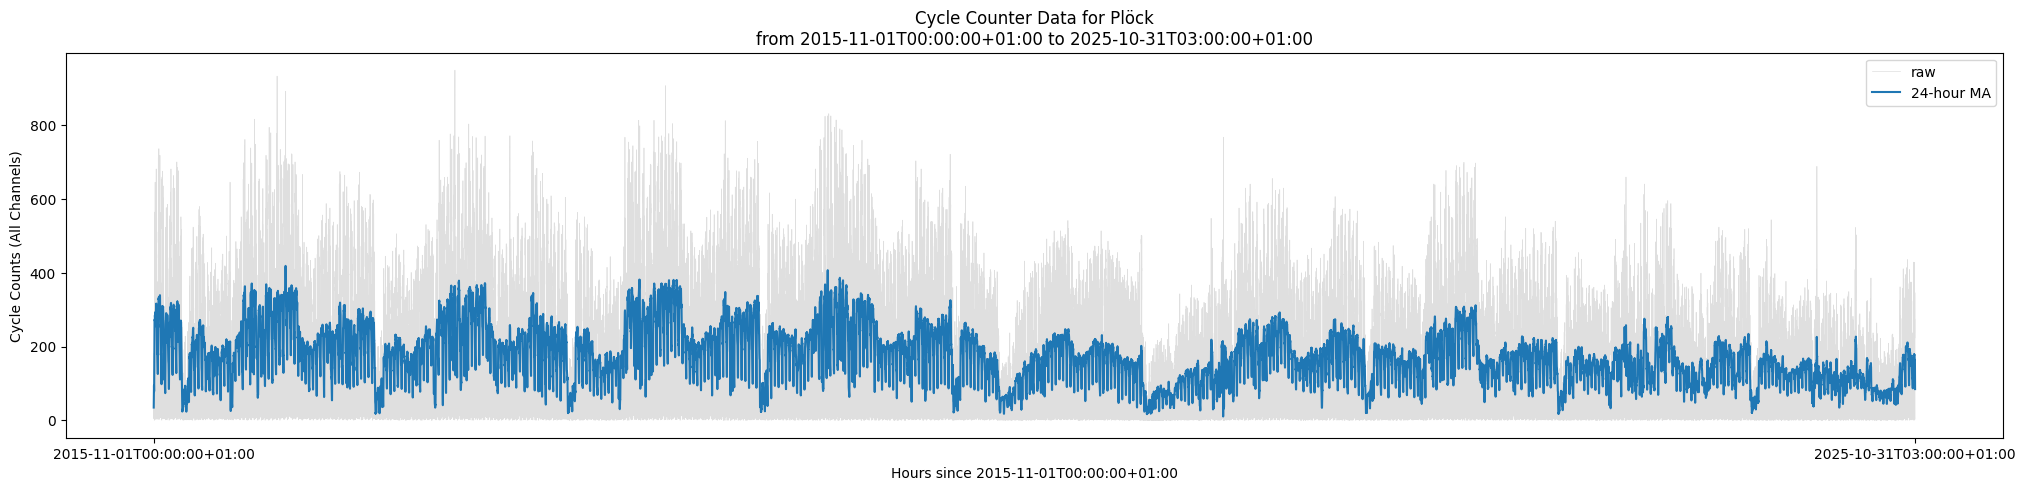

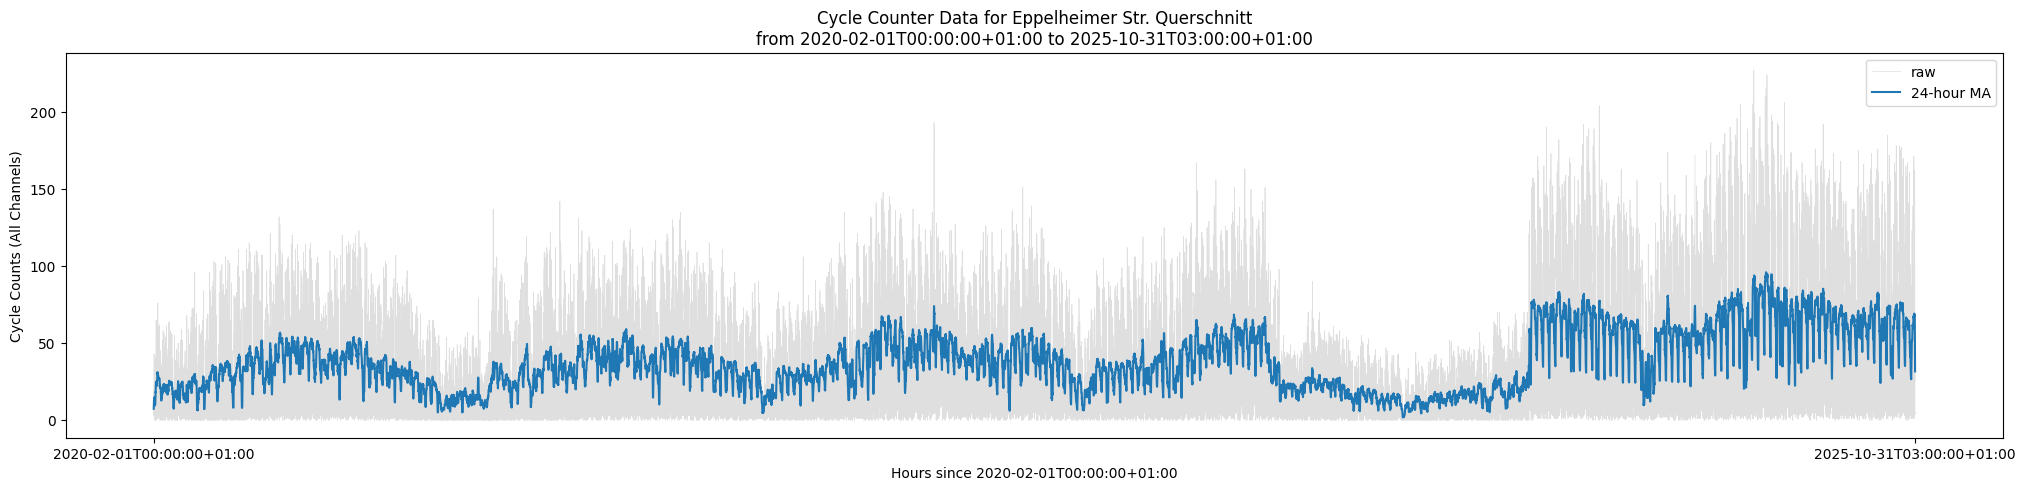

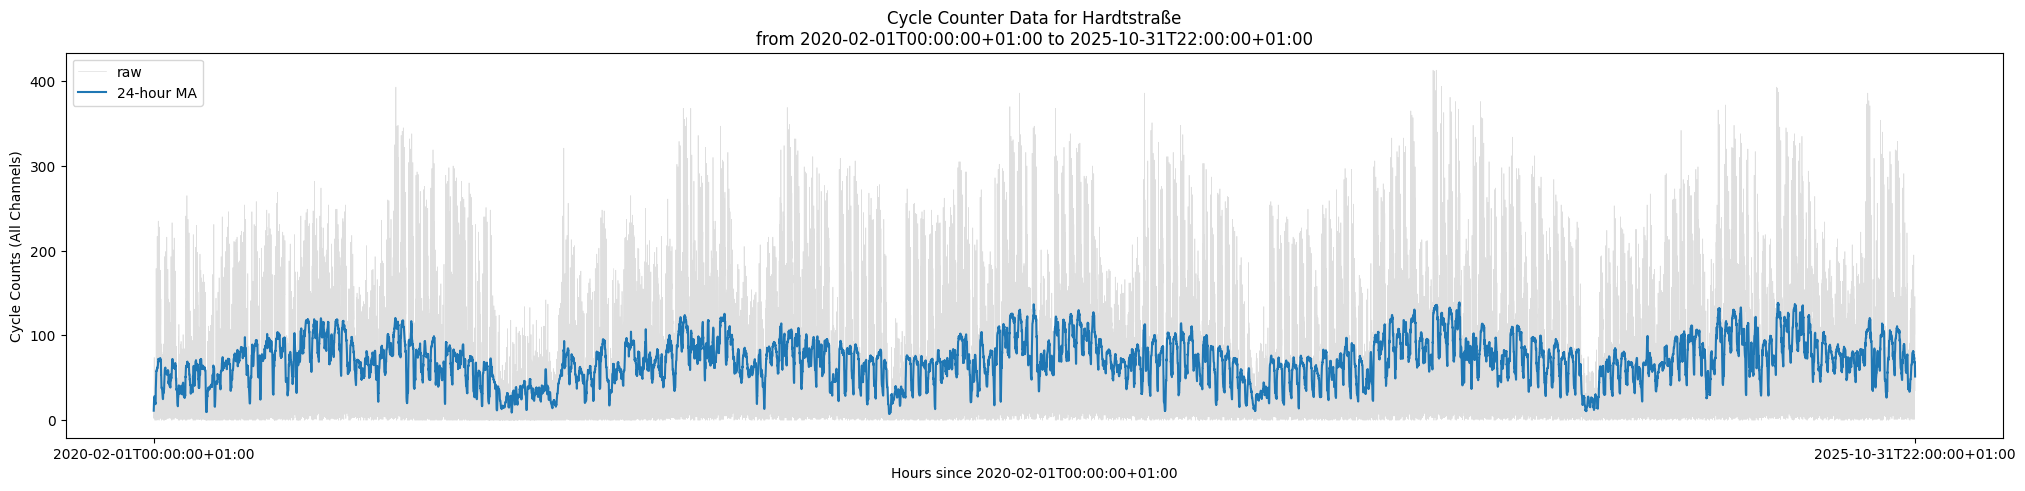

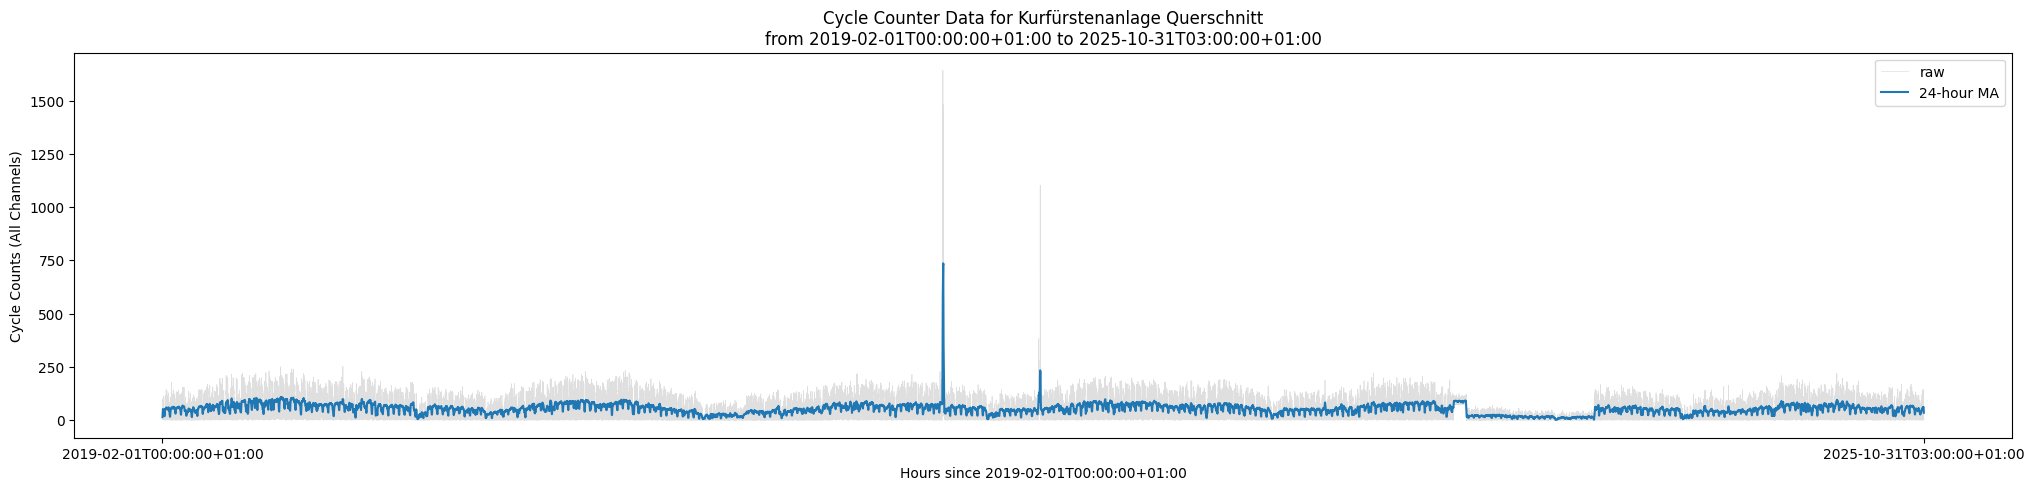

In [9]:
for station_name, (data, start_date, end_date) in hourly_data.items():
    print_series(data, start_date, end_date, station_name)
    

In [10]:

def plot_fft_cycle(data, station_name, start_date, end_date):
    n = len(data)
    timestep = 1  # assuming hourly data, so 1 hour between samples
    freq = np.fft.rfftfreq(n, d=timestep)
    fft_values = np.fft.rfft(data)
    fft_magnitude = np.abs(fft_values)
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=freq, y=fft_magnitude, color='tab:blue')
    plt.title(f'FFT of Cycle Counts for {station_name}\nfrom {start_date} to {end_date}')
    plt.xlabel('Frequency (cycles per hour)')
    plt.ylabel('Magnitude')
    plt.grid(True)
    plt.show()

In [11]:
#normalize data before FFT
normalized= {}
for station_name, (data, start_date, end_date) in hourly_data.items():
    data_mean = np.mean(data)
    data_std = np.std(data)
    normalized_data = (data - data_mean) / data_std
    normalized[station_name] = (normalized_data , start_date, end_date)

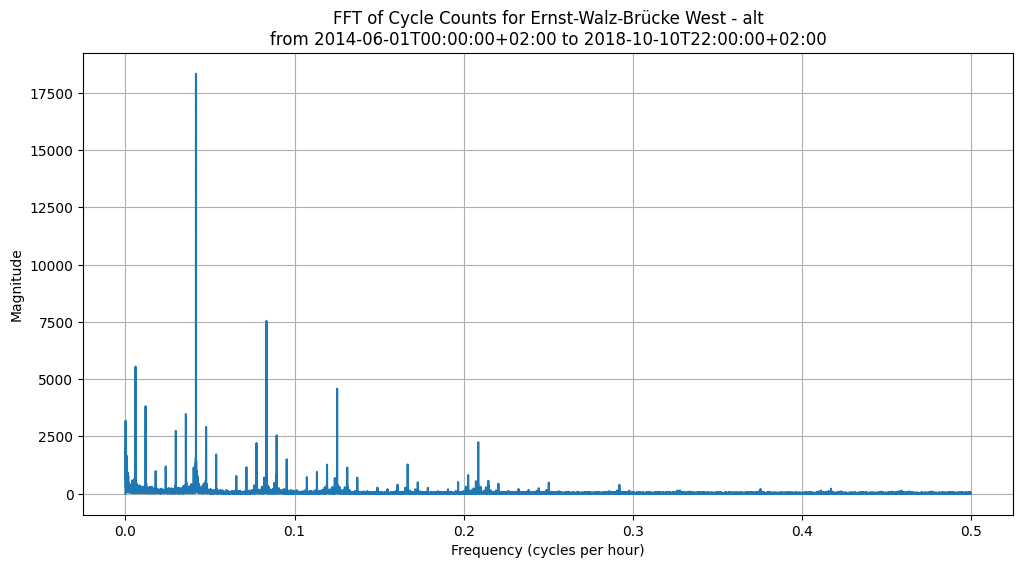

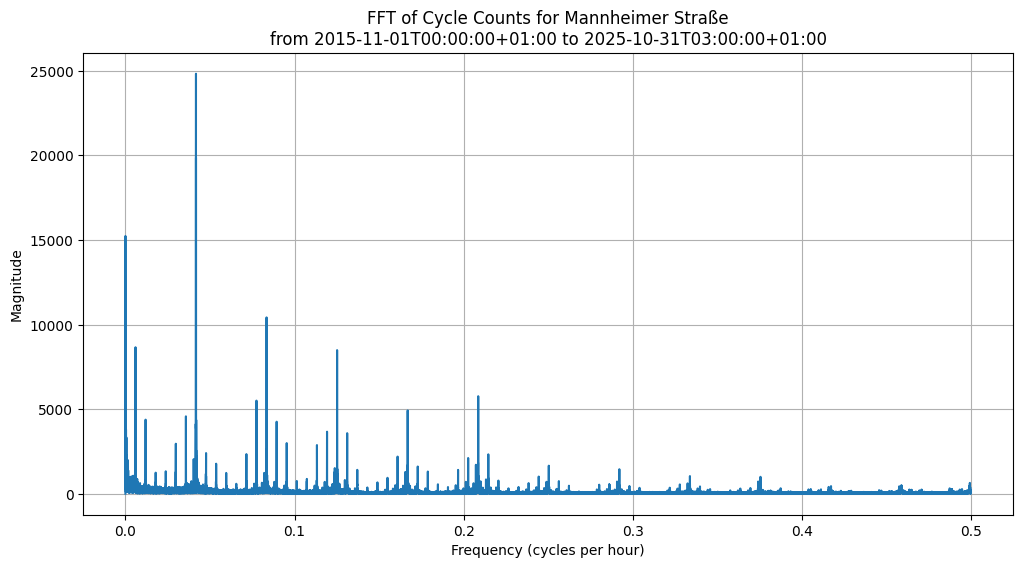

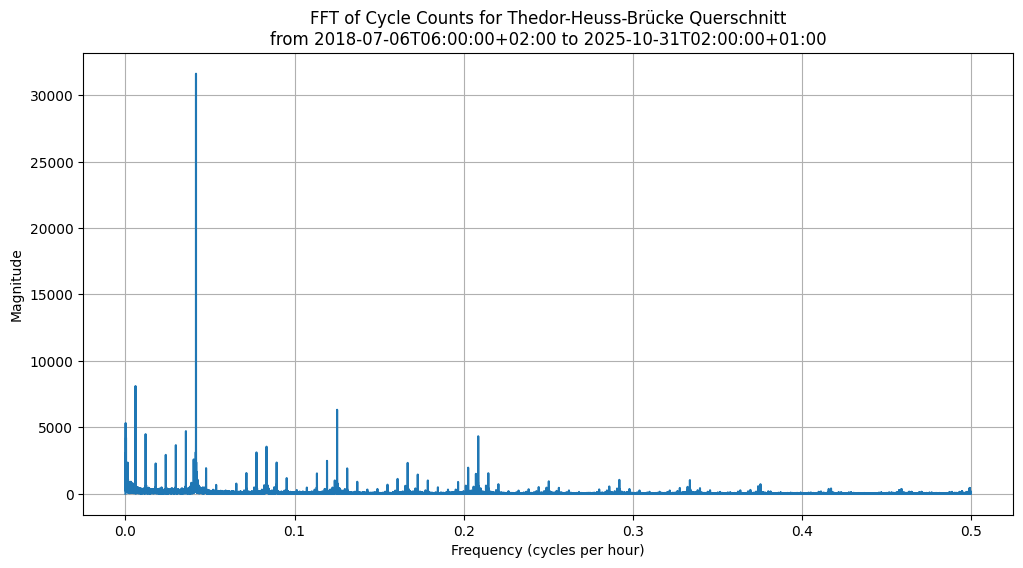

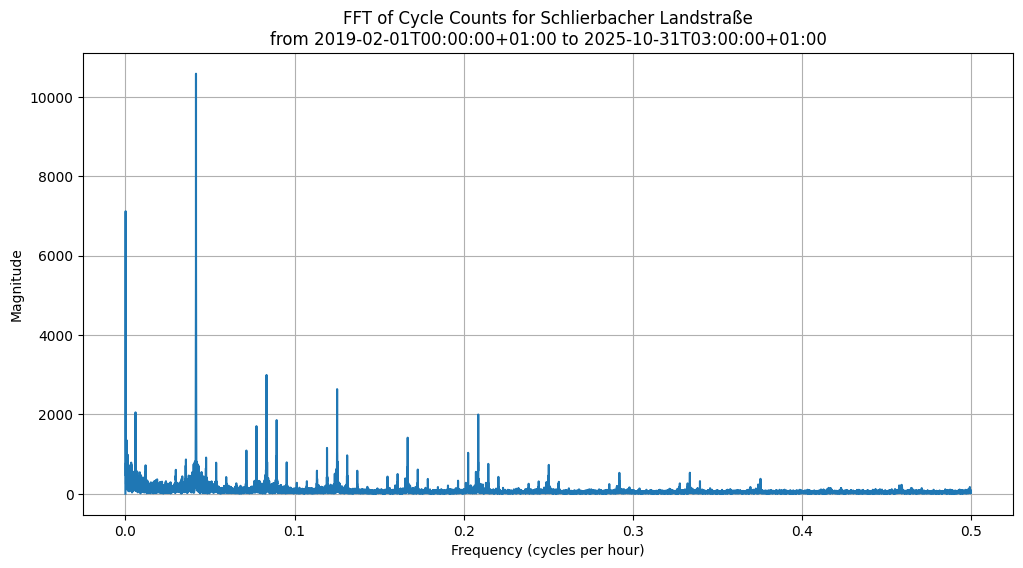

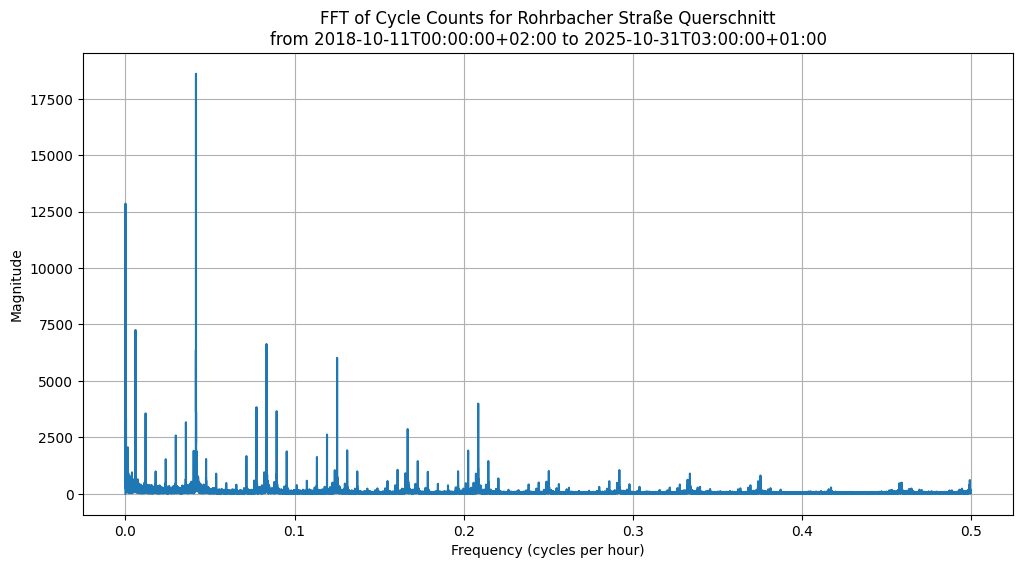

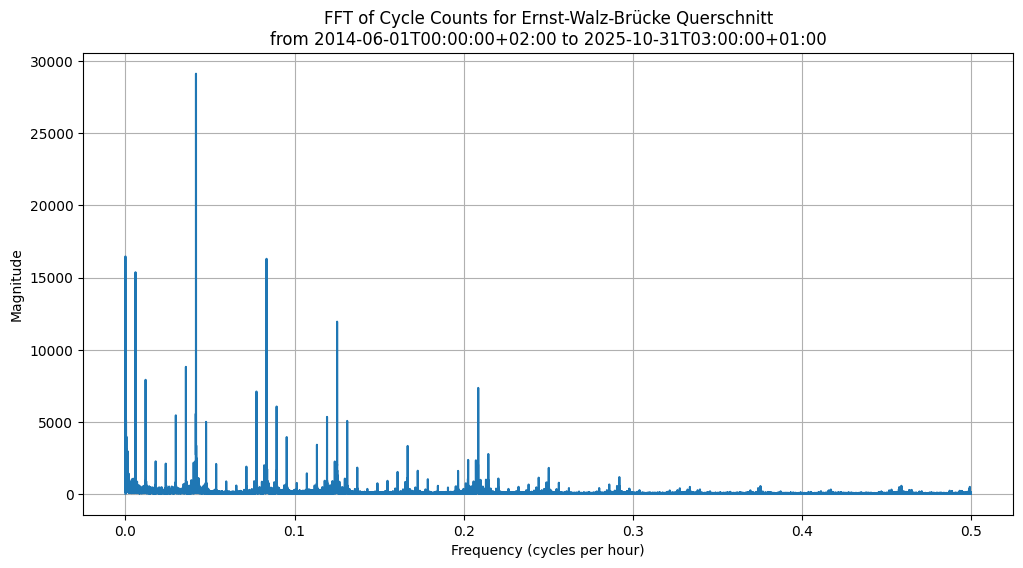

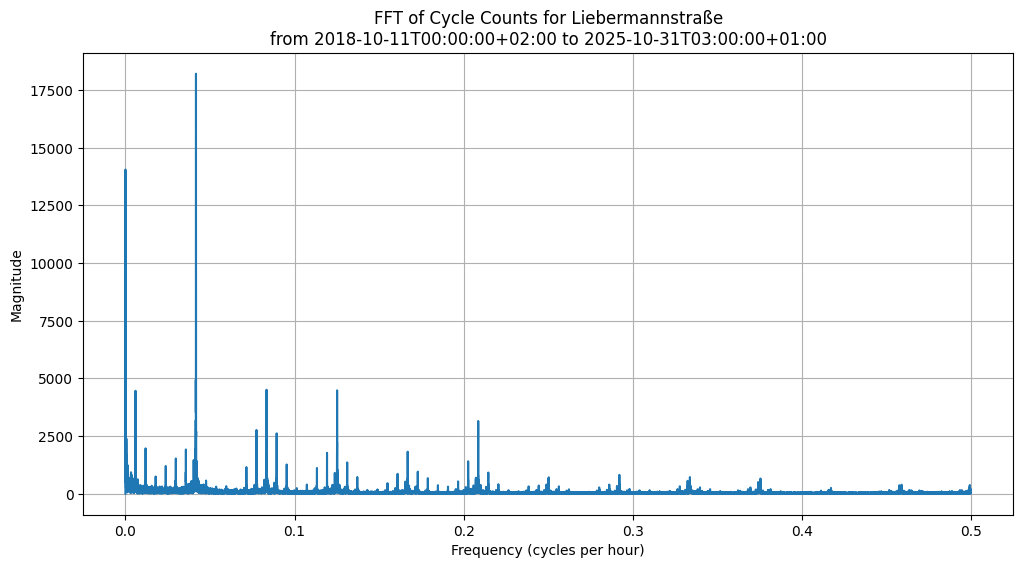

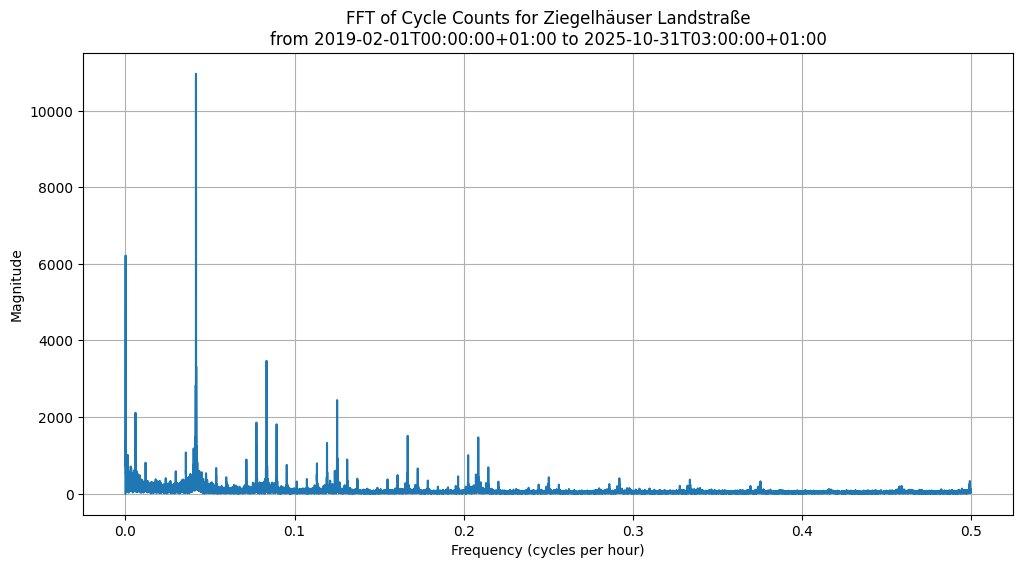

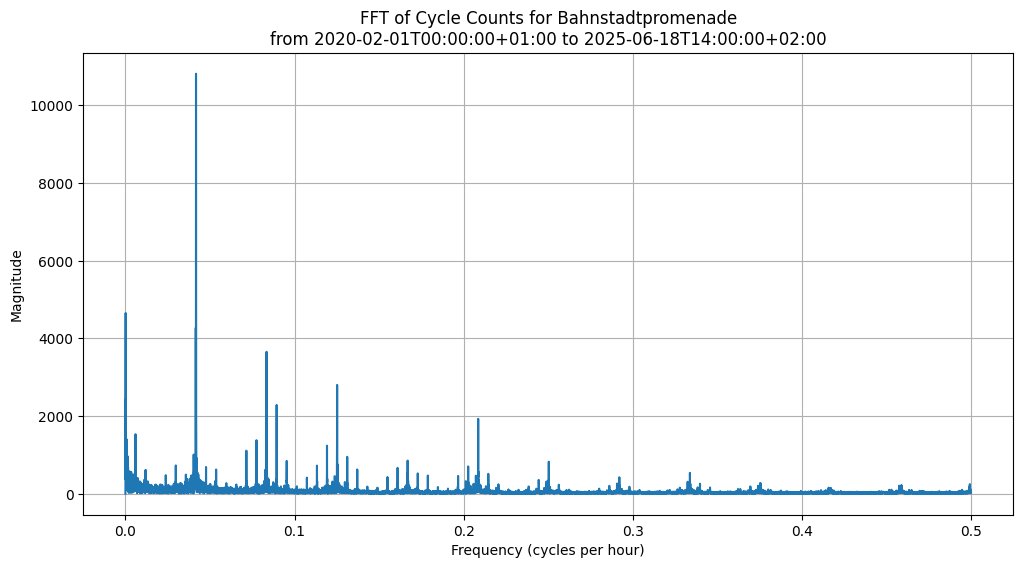

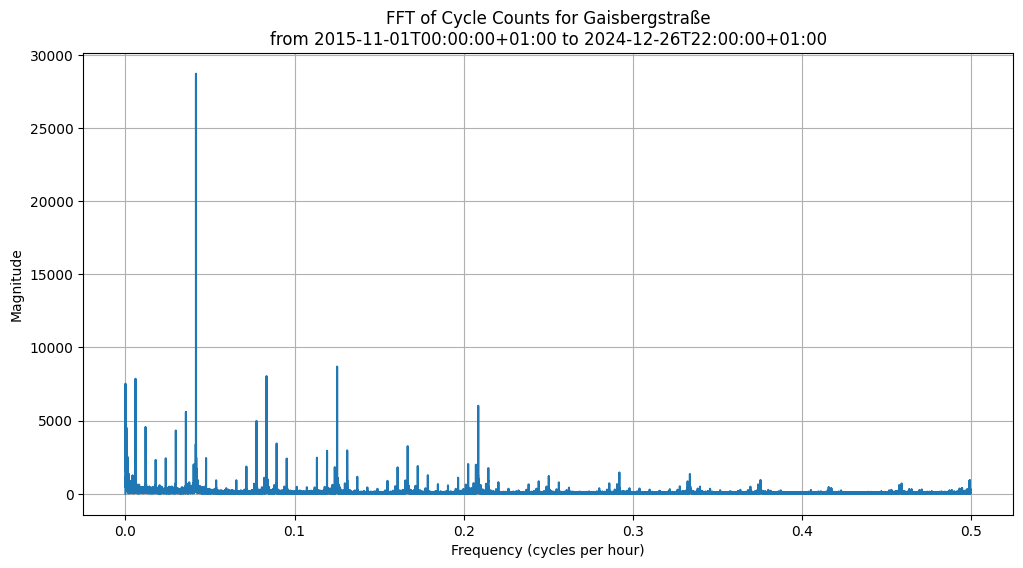

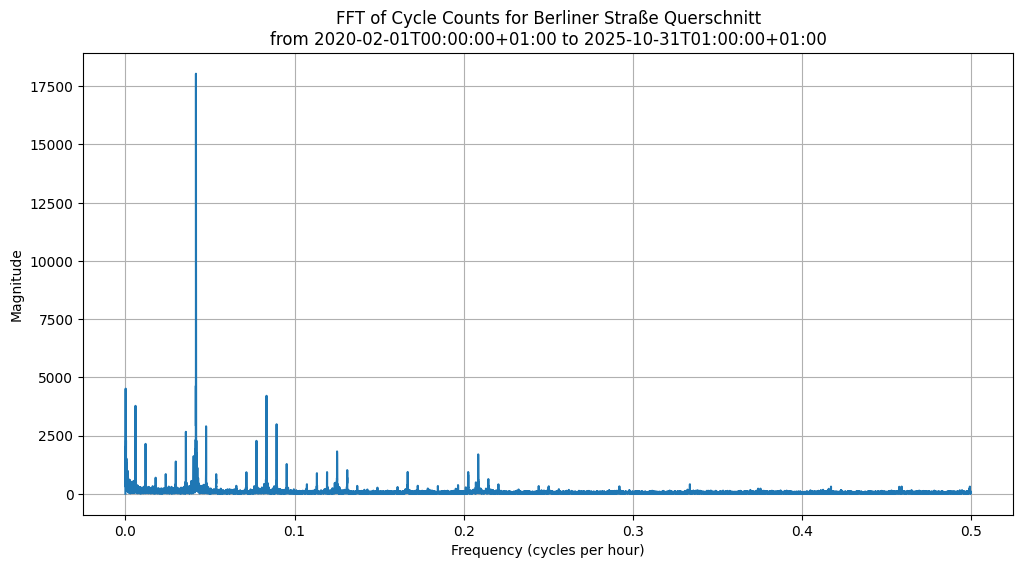

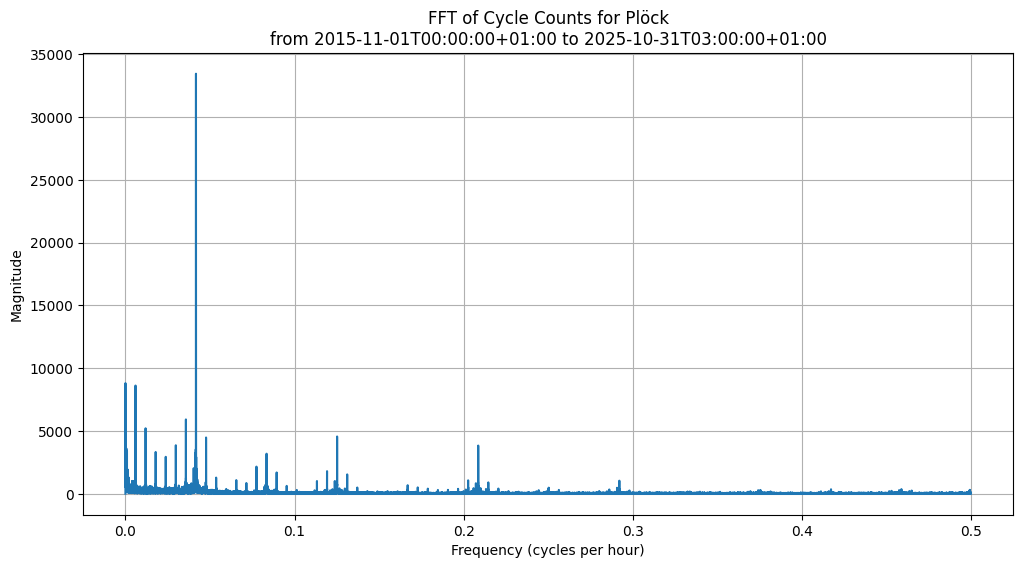

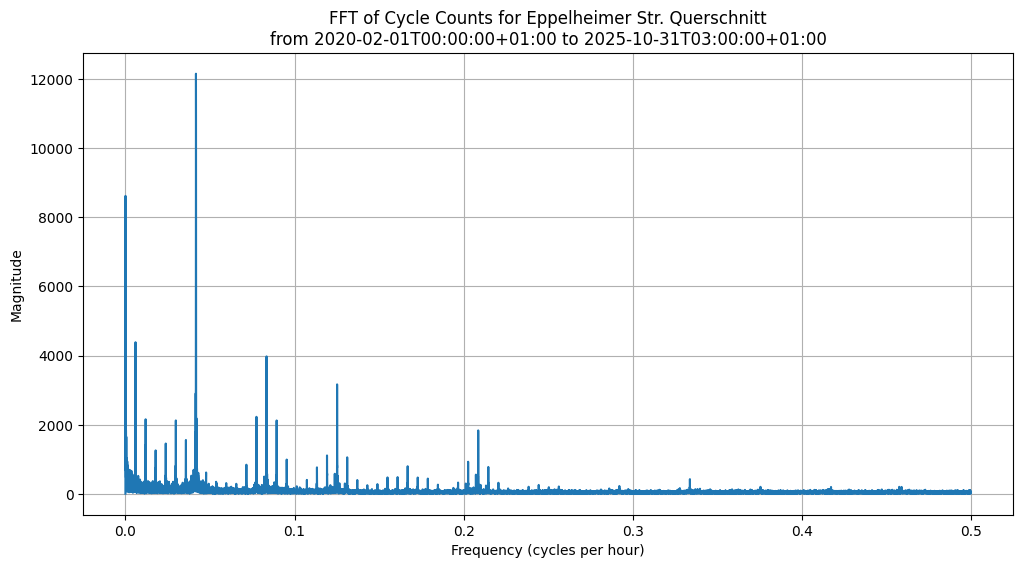

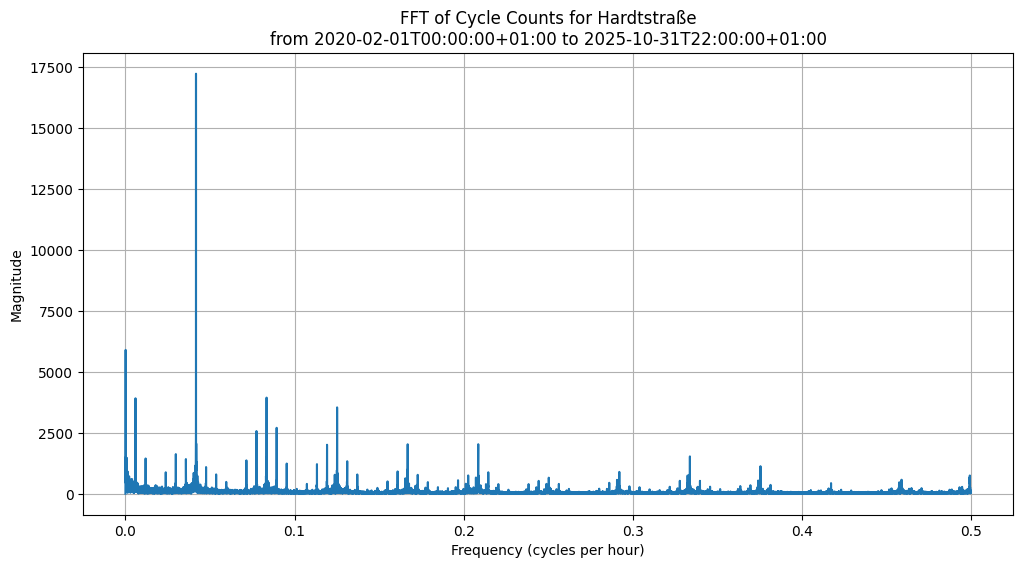

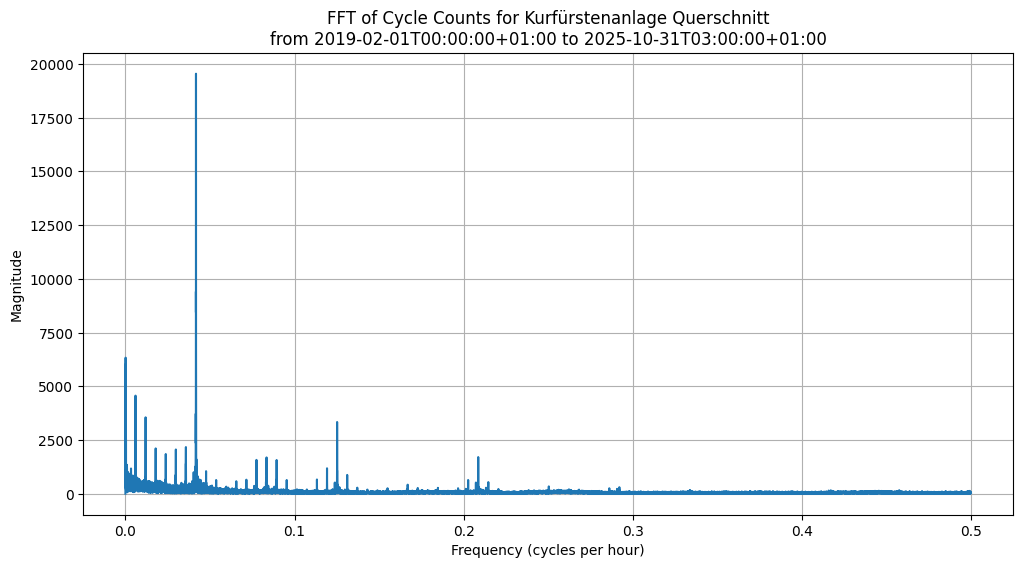

In [12]:
# plot the normalized data
for station_name, (data, start_date, end_date) in normalized.items():
    plot_fft_cycle(data, station_name, start_date, end_date)

In [14]:
# Print dominant frequencies in interpretable format
for station_name, (data, start_date, end_date) in normalized.items():
    n = len(data)
    if n == 0:
        continue
    
    timestep = 1  # hours
    freq = np.fft.rfftfreq(n, d=timestep)
    fft_values = np.fft.rfft(data)
    fft_magnitude = np.abs(fft_values)
    
    # Focus on low frequencies (< 0.5 cycles/hour)
    mask = freq <= 0.5
    freq_filtered = freq[mask]
    mag_filtered = fft_magnitude[mask]
    
    # Get top 10 components (skip DC at index 0)
    top_indices = np.argsort(mag_filtered[1:])[-10:] + 1
    top_indices = top_indices[::-1]  # highest to lowest magnitude
    
    print(f"\n{'='*80}")
    print(f"Station: {station_name}")
    print(f"Date Range: {start_date} to {end_date}")
    print(f"{'='*80}")
    print(f"{'Rank':<6} {'Frequency':<15} {'Period (hours)':<18} {'Period (days)':<15} {'Magnitude':<12}")
    print(f"{'-'*80}")
    
    for rank, idx in enumerate(top_indices, 1):
        freq_val = freq_filtered[idx]
        mag_val = mag_filtered[idx]
        period_hours = 1 / freq_val if freq_val > 0 else float('inf')
        period_days = period_hours / 24
        
        print(f"{rank:<6} {freq_val:<15.6f} {period_hours:<18.2f} {period_days:<15.2f} {mag_val:<12.1f}")


Station: Ernst-Walz-Brücke West - alt
Date Range: 2014-06-01T00:00:00+02:00 to 2018-10-10T22:00:00+02:00
Rank   Frequency       Period (hours)     Period (days)   Magnitude   
--------------------------------------------------------------------------------
1      0.041729        23.96              1.00            18335.9     
2      0.083458        11.98              0.50            7543.3      
3      0.005972        167.43             6.98            5546.8      
4      0.125187        7.99               0.33            4584.0      
5      0.005946        168.17             7.01            4204.6      
6      0.011919        83.90              3.50            3818.4      
7      0.035756        27.97              1.17            3479.1      
8      0.000105        9543.75            397.66          3184.6      
9      0.047701        20.96              0.87            2914.8      
10     0.029810        33.55              1.40            2741.1      

Station: Mannheimer Straße
Date